Modeling distributions
=================

Copyright 2015 Allen Downey

License: [Creative Commons Attribution 4.0 International](http://creativecommons.org/licenses/by/4.0/)

In [1]:
from __future__ import print_function, division

import analytic
import brfss
import nsfg

import thinkstats2
import thinkplot

import pandas as pd
import numpy as np
import math

%matplotlib inline

This notebook is about ways to model data using analytic distributions.  I start with the exponential distribution, which is often a good model of time between random arrivals.

On December 18, 1997, 44 babies were born in a hospital in Brisbane, Australia.  The time of birth for all 44 babies was reported in the local paper; the complete dataset is in a file called `babyboom.dat`.

If the times of birth are random, we expect the times between births to fit an exponential model.

Here's what the exponential CDF looks like for a range of parameters.

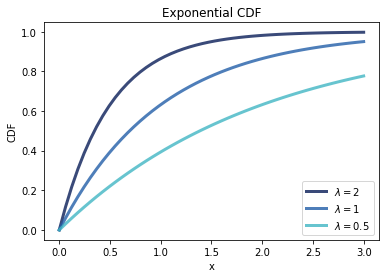

In [2]:
thinkplot.PrePlot(3)
for lam in [2.0, 1, 0.5]:
    xs, ps = thinkstats2.RenderExpoCdf(lam, 0, 3.0, 50)
    label = r'$\lambda=%g$' % lam
    thinkplot.Plot(xs, ps, label=label)
    
thinkplot.Config(title='Exponential CDF',
                 xlabel='x',
                 ylabel='CDF',
                 loc='lower right')    

Here's the babyboom data:

In [3]:
df = analytic.ReadBabyBoom()
df

,time,sex,weight_g,minutes
0,5,1,3837,5
1,104,1,3334,64
2,118,2,3554,78
3,155,2,3838,115
4,257,2,3625,177
5,405,1,2208,245
6,407,1,1745,247
7,422,2,2846,262
8,431,2,3166,271
9,708,2,3520,428


And here's the CDF of interarrival times.

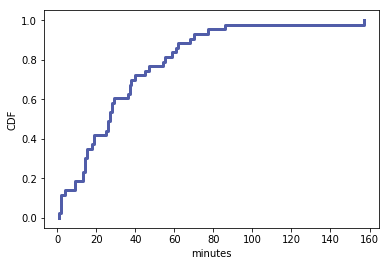

In [4]:
diffs = df.minutes.diff()
cdf = thinkstats2.Cdf(diffs, label='actual')

thinkplot.PrePlot(1)
thinkplot.Cdf(cdf)
thinkplot.Config(xlabel='minutes',
                 ylabel='CDF',
                 legend=False)

Visually it looks like an exponential CDF, but there are other analytic distributions that also look like this.  A stronger test is to plot the complementary CDF, that is $1-CDF(x)$ on a log-y scale.

If the data are from an exponential distribution, the result should approximate a straight line.

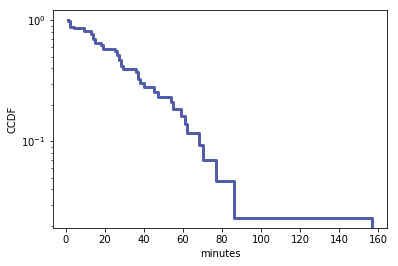

In [5]:
thinkplot.PrePlot(1)
thinkplot.Cdf(cdf, complement=True)
thinkplot.Config(xlabel='minutes',
                 ylabel='CCDF',
                 yscale='log',
                 legend=False)

It is not exactly straight, which indicates that the exponential distribution is not a perfect model for this data. Most likely the underlying assumption—that a birth is equally likely at any time of day—is not exactly true. Nevertheless, it might be reasonable to model this dataset with an exponential distribution.

As George Box said, "All models are wrong, but some are useful".

### The normal distribution

Many quantities in the natural world are well modeled by a normal distribution, also known as a Gaussian.

Here is what the CDF of a normal distriubution looks like for a few different parameter values:

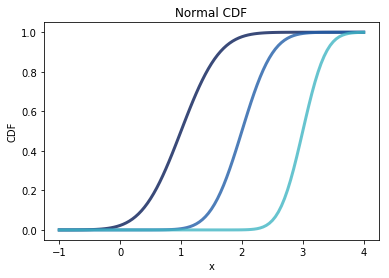

In [6]:
thinkplot.PrePlot(3)

mus = [1.0, 2.0, 3.0]
sigmas = [0.5, 0.4, 0.3]
for mu, sigma in zip(mus, sigmas):
    xs, ps = thinkstats2.RenderNormalCdf(mu=mu, sigma=sigma, 
                                               low=-1.0, high=4.0)
    label = r'$\mu=%g$, $\sigma=%g$' % (mu, sigma)
    thinkplot.Plot(xs, ps, label=label)

thinkplot.Config(title='Normal CDF',
                 xlabel='x',
                 ylabel='CDF',
                 loc=2)
 

We might expect the distribution of birth weights to be approximately normal.  I'll load data from the NSFG again:

In [7]:
preg = nsfg.ReadFemPreg()
weights = preg.totalwgt_lb.dropna()

We can estimate the parameters of the normal distribution, `mu` and `sigma`, then plot the data on top of the analytic model:

Mean, Var 7.28088310002 1.54521257035
Sigma 1.2430657948614345


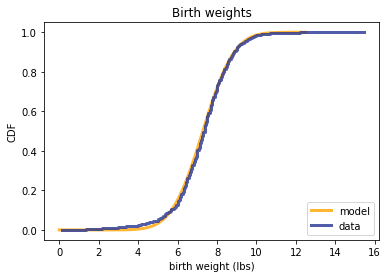

In [8]:
mu, var = thinkstats2.TrimmedMeanVar(weights, p=0.01)
print('Mean, Var', mu, var)
    
    # plot the model
sigma = math.sqrt(var)
print('Sigma', sigma)
xs, ps = thinkstats2.RenderNormalCdf(mu, sigma, low=0, high=12.5)

thinkplot.Plot(xs, ps, label='model', color='orange')

    # plot the data
cdf = thinkstats2.Cdf(weights, label='data')

thinkplot.PrePlot(1)
thinkplot.Cdf(cdf) 
thinkplot.Config(title='Birth weights',
                   xlabel='birth weight (lbs)',
                   ylabel='CDF',
                   legend=True)

The data fit the model well, but there are some deviations in the lower tail.

To get a better view of the tails, we can use a normal probability plot, which plots the actual data versus sorted values from random normal values.

In [9]:
def NormalProbability(ys, jitter=0.0):
    """Generates data for a normal probability plot.

    ys: sequence of values
    jitter: float magnitude of jitter added to the ys 

    returns: numpy arrays xs, ys
    """
    n = len(ys)
    xs = np.random.normal(0, 1, n)
    xs.sort()
    
    if jitter:
        ys = Jitter(ys, jitter)
    else:
        ys = np.array(ys)
    ys.sort()

    return xs, ys

If the data are normal, the result should be a straight line.

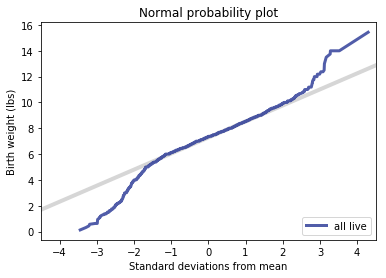

In [10]:
mean, var = thinkstats2.TrimmedMeanVar(weights, p=0.01)
std = math.sqrt(var)

xlim = [-4.5, 4.5]
fxs, fys = thinkstats2.FitLine(xlim, mean, std)
thinkplot.Plot(fxs, fys, linewidth=4, color='0.8')

thinkplot.PrePlot(2) 
xs, ys = NormalProbability(weights)
thinkplot.Plot(xs, ys, label='all live')

thinkplot.Config(title='Normal probability plot',
                 xlabel='Standard deviations from mean',
                 ylabel='Birth weight (lbs)',
                 legend=True, loc='lower right',
                 xlim=xlim)

The normal probability plot shows that the lightest babies are lighter than expected, starting about two standard deviations below the mean.  Also, the heaviest babies are heavier than the model predicts.

The NSFG data includes premature babies; if we select full-term babies, we might expect the normal model to be a better fit.

In [11]:
full_term = preg[preg.prglngth >= 37]
term_weights = full_term.totalwgt_lb.dropna()

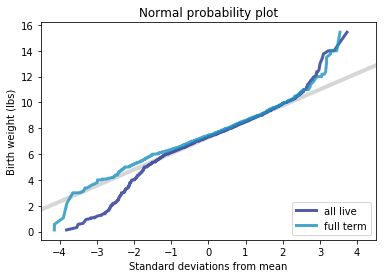

In [12]:
thinkplot.Plot(fxs, fys, linewidth=4, color='0.8')

thinkplot.PrePlot(2) 
xs, ys = NormalProbability(weights)
thinkplot.Plot(xs, ys, label='all live')

xs, ys = NormalProbability(term_weights)
thinkplot.Plot(xs, ys, label='full term')

thinkplot.Config(title='Normal probability plot',
                 xlabel='Standard deviations from mean',
                 ylabel='Birth weight (lbs)',
                 legend=True, loc='lower right',
                 xlim=xlim)

As expected, the normal model is a better fit for full-term babies at the low end of the distribution.

But it turns out that the normal model does not do very well for adult weight.  I'll load data from the BRFSS.

In [13]:
df = brfss.ReadBrfss()
weights = df.wtkg2.dropna()
log_weights = np.log10(weights)

This function generates normal probability plots:

In [27]:
def MakeNormalPlot(weights):
    """Generates a normal probability plot of birth weights.

    weights: sequence
    """
    mean, var = thinkstats2.TrimmedMeanVar(weights, p=0.01)
    std = math.sqrt(var)

    xs = [-5, 5]
    xs, ys = thinkstats2.FitLine(xs, mean, std)
    thinkplot.Plot(xs, ys, color='0.8', label='model')

    xs, ys = thinkstats2.NormalProbability(weights)
    thinkplot.Plot(xs, ys, label='weights')


The normal distribution is a poor model for the distribution of adult weights.

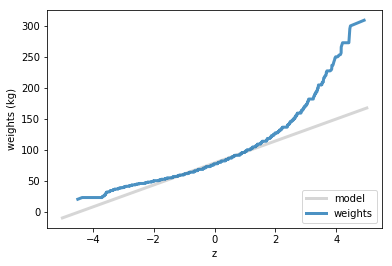

In [28]:
MakeNormalPlot(weights)
thinkplot.Config(xlabel='z', ylabel='weights (kg)')

But if we compute the log of adult weights, the normal distribution is much better.

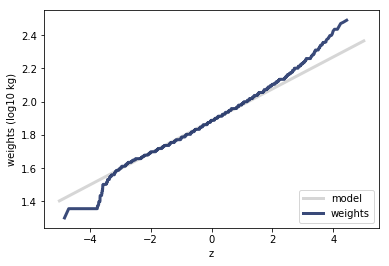

In [29]:
MakeNormalPlot(log_weights)
thinkplot.Config(xlabel='z', ylabel='weights (log10 kg)')

Within 3 standard deviations of the mean, the normal model does quite well, although the heaviest and lightest people diverge from the model.

If $\log x$ has a normal distribution, $x$ has a lognormal distribution.